# ADA milestone P4: creative extension of 'Signed Network in Social Media'

### **Outline**:
* 1. Data Wrangling
    * 1.1 Reading the datasets
    * 1.2 Recreating the paper's settings
        * 1.2.1 Epinions and user_rating
        * 1.2.2 Selecting the same edges than in the paper
    * 1.3 Combining the datasets
        * 1.3.1 Computing user-centered features
        * 1.3.2 Merging the member's features with the edges' dataframe (status_dataset)
* 2. Data Analysis
    * 2.1 Users statistics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics 
import math
import scipy
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold 
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

## 1. Data Wrangling

We wish to combine the informations from three datasets to extract meaningful features for our model

### 1.1 Reading the datasets

#### **Ratings**

Ratings are quantified statements made by users regarding the quality of a content in the site. Ratings is the basis on which the contents are sorted and filtered.

Column Details:

* OBJECT_ID The object ID is the object that is being rated. The only valid objects at the present time are the content_id of the member_content table. This means that at present this table only stores the ratings on reviews and essays
* MEMBER_ID Stores the id of the member who is rating the object
* RATING Stores the 1-5 (1- Not helpful , 2 - Somewhat Helpful, 3 - Helpful 4 - Very Helpful 5- Most Helpful) rating of the object by member [There are some 6s, treat them as 5]
* STATUS The display status of the rating. 1 :- means the member has chosen not to show his rating of the object and 0 meaning the member does not mind showing his name beside the rating. **We renamed this feature 'anonymity' to avoid confusion with the notion of status in triads theory**
* CREATION The date on which the member first rated this object
* LAST_MODIFIED The latest date on which the member modified his rating of the object
* TYPE If and when we allow more than just content rating to be stored in this table, then this column would store the type of the object being rated.
* VERTICAL_ID Vertical_id of the review.

In [2]:
ratings = pd.read_csv('data/rating.txt', delimiter='\t',header=None)
ratings = ratings.rename(columns = {0:'object_id', 1:'member_id',2:'rating',3:'anonymity',4:'creation',5:'last_modified',6:'type',7:'vertical_id'})

# We only select the features that are of interest for our analysis

# TODO: rename status for anonymity so we don't get confused !!
ratings = ratings[['object_id','member_id','rating','anonymity','type']]

ratings["rating"] = ratings["rating"].apply(lambda x: (x-1) if x == 6 else x)
ratings.head()

,object_id,member_id,rating,anonymity,type
0,139431556,591156,5,0,1
1,139431556,1312460676,5,0,1
2,139431556,204358,5,0,1
3,139431556,368725,5,0,1
4,139431556,277629,5,0,1


#### **mc**

Each article is written by a user.

Column Details:

* CONTENT_ID The object ID of the article.
* AUTHOR_ID The ID of the user who wrote the article
* SUBJECT_ID The ID of the subject that the article is supposed to be about

In [3]:
mc = pd.read_csv('data/mc.txt.gz', delimiter='|',header=None)
mc = mc.rename(columns = {0:'content_id', 1:'author_id',2:'subject_id'})
mc.head()

,content_id,author_id,subject_id
0,1445594,718357,1.490024e+11
1,1445595,220568,1.490036e+11
2,1445596,717325,5.303145e+09
3,1445597,360156,1.926209e+11
4,1445598,718857,1.490022e+11


#### **User ratings**

Trust is the mechanism by which the user makes a statement that they like the content or the behavior of particular user and would like to see more of what the users does in the site. Distrust is the opposite of the trust in which the user says that they do want to see lesser of the operations performed by that user.

Column Details:

* MY_ID This stores Id of the member who is making the trust/distrust statement
* OTHER_ID The other ID is the ID of the member being trusted/distrusted
* VALUE Value = 1 for trust and -1 for distrust
* CREATION It is the date on which the trust was made

In [7]:
user_ratings = pd.read_csv('data/user_rating.txt.gz', delimiter='\t', header=None)
user_ratings = user_ratings.rename(columns={0:'FromNodeId',1:'ToNodeId',2:'Sign',3:'Creation'})
user_ratings.head()

,FromNodeId,ToNodeId,Sign,Creation
0,3287060356,232085,-1,2001/01/10
1,3288305540,709420,1,2001/01/10
2,3290337156,204418,-1,2001/01/10
3,3294138244,269243,-1,2001/01/10
4,3294138244,170692484,-1,2001/01/10


#### **Epinions**

This dataset was the one given for the replication in milestone 2. The replication showed that it has the same statistics than the one used by the paper's author.

It has the same columns than the *user_ratings* dataset, minus the creation data, which is a feature that we will want to use. 

In the next step, we will see if *user_ratings* contains the same network as in *epinions* dataset and can be used as substitution while keeping the same data than in the paper.

In [9]:
epinions_given = pd.read_csv('data/soc-sign-epinions.txt', delimiter='\t', header=3)
epinions_given = epinions_given.rename(columns={'# FromNodeId':'FromNodeId'})
epinions_given.head()

,FromNodeId,ToNodeId,Sign
0,0,1,-1
1,1,128552,-1
2,2,3,1
3,4,5,-1
4,4,155,-1


### 1.2 Recreating the paper's settings

#### 1.2.1 epinions & user_ratings

Our first task is to determine if *epinions* and *user_ratings* can be used interchangeably.

In [10]:
print(epinions_given.index)
print(user_ratings.index)

RangeIndex(start=0, stop=841372, step=1)
RangeIndex(start=0, stop=841372, step=1)


We first notice that they have the same size, good news! 
Do they have the same set of nodes and edges?

In [11]:
ep_range = [min(epinions_given['FromNodeId'].min(), epinions_given['ToNodeId'].min()), 
            max(epinions_given['FromNodeId'].max(), epinions_given['ToNodeId'].max())]
ur_range = [min(user_ratings['FromNodeId'].min(), user_ratings['ToNodeId'].min()), 
            max(user_ratings['FromNodeId'].max(), user_ratings['ToNodeId'].max())]

print(f"The range of node Ids in the given Epinions data set is {ep_range}")
print(f"The range of node Ids in the user ratings data set is {ur_range}")

The range of node Ids in the given Epinions data set is [0, 131827]
The range of node Ids in the user ratings data set is [199781, 84015157124]


The two graphs don't use the same range of node Ids so we can't find a straightforward mapping between the two. We use the vf2 algorithm with the igraph library to determine if one is an isomorphism of the other.

In [12]:
import igraph as ig

ur_graph = ig.Graph.TupleList(user_ratings.itertuples(index=False), edge_attrs = 'Creation', 
                              directed=True)
ep_graph = ig.Graph.TupleList(epinions_given.itertuples(index=False), 
                              directed=True)
ur_graph.isomorphic_vf2(ep_graph, edge_color1 = user_ratings['Sign'], edge_color2 = epinions_given['Sign'])

True

Great! From now on, we will only use the user_ratings dataset, with the knowledge that it holds the same properties and distribution as in the original paper.

#### 1.2.2 Selecting the same edges as in the paper

One of the findings of the paper is that in the setting of contextualized links, most triadic types are consistent with status theory. As we are interested in the notion of status, we will reproduce the conditions in which status theory is dominant, and in which we can interpret a positive link from A to B as B having a higher status than A.

A contextualized link (A,B:X) is a link forms between A and B *after* both A and B have formed a link with X. These are the red edges in the figure below, and they are the only one we will keep in our analysis.
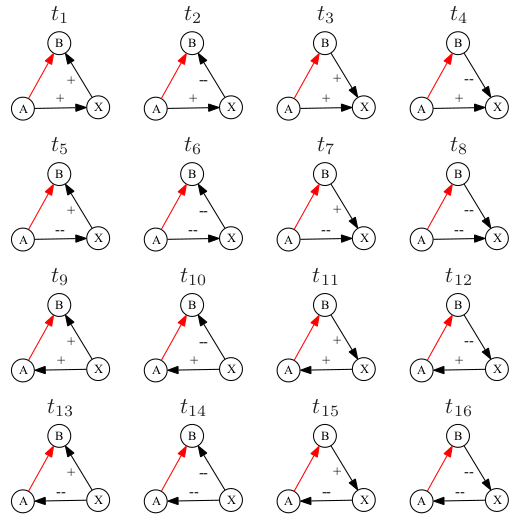

**TODO: insert here the code for selecting the edges**

In [34]:
status_dataset = user_ratings.copy()
edge_types_counter = pd.read_pickle('data/edge_types.pkl')
edge_types_counter = edge_types_counter.rename(columns={'NodeA':'FromNodeId','NodeB':'ToNodeId'})
status_dataset = status_dataset.merge(edge_types_counter)
print(status_dataset.shape)


### 1.3 Combining the datasets

#### 1.3.1 Computing user-centered features

We want to extract from the other datasets user-centric features.
We first use the **ratings** data set to compute the average rating, the anonymity frequency, sensionalism and the number of reviews written by the users. We will also use the **mc** dataset to compute the number of articles written by each users

In [39]:
members = pd.DataFrame(index = ratings['member_id'].unique())

# average ratings
members['avg_ratings'] = ratings[['member_id', 'rating']].groupby('member_id').mean()

# anonymity frequency
members['anonymity_freq'] = ratings[['member_id', 'anonymity']].groupby('member_id').mean()

# sensionalism: average of how much the review differs from the mean rating of the object
mean_rating = ratings[['object_id', 'rating']].groupby('object_id').mean()
mean_rating = mean_rating.rename(columns = {'rating': 'mean_rating'})
ratings = pd.merge(ratings, mean_rating.reset_index(), on = 'object_id')
ratings['diff_from_mean'] = np.absolute(ratings['rating'] - ratings['mean_rating'])
members['sensationalism'] = ratings[['member_id', 'diff_from_mean']].groupby('member_id').mean()

# number of reviews made
members['nbr_reviews'] = ratings.groupby('member_id').size()

# number of articles written. If a user is not in this list, it means that they haven't written any articles. 
# In this case, we set nbr_articles = 0 
members['nbr_articles'] = mc.groupby('author_id').size()
members = members.fillna(0)

In [49]:
print(members.shape)
members

(120492, 5)


,avg_ratings,anonymity_freq,sensationalism,nbr_reviews,nbr_articles
591156,4.847283,0.033774,0.250845,681,36.0
1312460676,4.631902,0.007362,0.227751,815,17.0
204358,4.718543,0.012712,0.208986,11643,115.0
368725,4.374117,0.005527,0.222522,6514,104.0
277629,4.427660,0.001984,0.273555,7057,142.0
...,...,...,...,...,...
331302,5.000000,0.000000,0.129032,1,1.0
223182,4.000000,0.000000,0.928571,1,0.0
316272,5.000000,0.000000,0.000000,1,1.0
309002,2.000000,0.000000,2.903226,1,0.0


#### 1.3.2 merging the member's features with the edges' dataframe (status_dataset)

We rename the nodes of each edge as node1 (source) and node2 (target) and all their features as {feature}{number} for simplicity. For example, the average rate of the source vertex becomes avg_rate1

In [41]:
status_dataset = status_dataset.rename(columns = {'FromNodeId': 'node1', 'ToNodeId': 'node2'})

# merge for the source node (node1)
status_dataset = pd.merge(status_dataset, members, left_on = 'node1', right_index = True)
status_dataset = status_dataset.rename(columns = {'avg_ratings': 'avg_ratings1', 
                                                  'anonymity_freq': 'anonymity_freq1',
                                                  'nbr_reviews': 'nbr_reviews1',
                                                  'nbr_articles': 'nbr_articles1',
                                                  'sensationalism': 'sensationalism1'})

# merge for the target node (node2)
status_dataset = pd.merge(status_dataset, members, left_on = 'node2', right_index = True)
status_dataset = status_dataset.rename(columns = {'avg_ratings': 'avg_ratings2', 
                                                  'anonymity_freq': 'anonymity_freq2',
                                                  'nbr_reviews': 'nbr_reviews2',
                                                  'nbr_articles': 'nbr_articles2',
                                                  'sensationalism': 'sensationalism1'})

status_dataset.reset_index(drop = True, inplace = True)

In [48]:
print(status_dataset.shape)
status_dataset.head()

(466817, 19)


,node1,node2,Sign,Creation,type,avg_ratings1,anonymity_freq1,avg_ratings2,anonymity_freq2,avg_ratings1,anonymity_freq1,sensationalism1,nbr_reviews1,nbr_articles1,avg_ratings2,anonymity_freq2,sensationalism1,nbr_reviews2,nbr_articles2
0,209227652,482665,1,2001/01/10,"[3, 1, 11, 9]",5.000000,0.000000,4.436782,0.019157,5.000000,0.000000,0.191199,16,3.0,4.436782,0.019157,0.343586,261,34.0
1,209424260,482665,1,2001/01/10,"[9, 11, 11, 3, 9, 1]",4.250000,0.000000,4.436782,0.019157,4.250000,0.000000,0.570238,4,3.0,4.436782,0.019157,0.343586,261,34.0
2,511995,482665,1,2001/01/10,"[10, 3]",4.000000,0.375000,4.436782,0.019157,4.000000,0.375000,1.124566,16,63.0,4.436782,0.019157,0.343586,261,34.0
3,533639,482665,1,2001/01/10,"[3, 9]",4.941574,0.000000,4.436782,0.019157,4.941574,0.000000,0.112702,3851,59.0,4.436782,0.019157,0.343586,261,34.0
4,508183,482665,1,2001/01/10,"[3, 15, 3, 11, 3, 9, 1]",4.854749,0.106145,4.436782,0.019157,4.854749,0.106145,0.821581,179,35.0,4.436782,0.019157,0.343586,261,34.0


## 2. Data Analysis

In [ ]:
ax = sns.distplot(members['nbr_reviews'], bins=40, kde=False);
ax.set_yscale('log')
ax.set(title='Distribution of the number of reviews by users', xlabel='number of reviews', ylabel='number of users')
plt.show()

In [ ]:
ax = sns.distplot(members['nbr_articles'], bins=40, kde=False);
ax.set_yscale('log')
ax.set(title='Distribution of the number of articles by users', xlabel='number of articles', ylabel='number of users')
plt.show()

In [ ]:
ax = sns.distplot(members['avg_ratings'], bins=40, kde=False);
ax.set(title='Distribution of mean rating', xlabel='mean rating', ylabel='number of users')
plt.show()

In [ ]:
ax = sns.distplot(members['anonymity_freq'], bins=40, kde=False);
ax.set_yscale('log')
ax.set(title='Distribution of anonymity frequency', xlabel='anonymity frequency', ylabel='number of users')
plt.show()

In [ ]:
ax = sns.distplot(members['sensationalism'], bins=20, kde=False);
ax.set(title='Distribution of sensationalism', xlabel='sensationalism', ylabel='number of users')
plt.show()

**I'm not sure I understand what is happening below**

In [ ]:
features = user_ratings.copy(deep=True)

In [ ]:
### log scale and normalize

features['FromId_posting_freq'] = features['FromId_posting_freq'].apply(lambda x: np.log(x) if x > 0 else 0)
features['FromId_articles_freq'] = features['FromId_articles_freq'].apply(lambda x: np.log(x) if x > 0 else 0)

features['ToId_posting_freq'] = features['ToId_posting_freq'].apply(lambda x: np.log(x) if x > 0 else 0)
features['ToId_articles_freq'] = features['ToId_articles_freq'].apply(lambda x: np.log(x) if x > 0 else 0)

features['FromId_posting_freq'] /= unique_nodes['Posting_freq'].max()
features['FromId_articles_freq'] /= unique_nodes['Articles_freq'].max()

features['ToId_posting_freq'] /= unique_nodes['Posting_freq'].max()
features['ToId_articles_freq'] /= unique_nodes['Articles_freq'].max()

In [ ]:
features['FromId_mean_rating'] /= unique_nodes['Mean_rating'].max()
features['FromId_sense_factor'] /= unique_nodes['Sensationalism'].max()

features['ToId_mean_rating'] /= unique_nodes['Mean_rating'].max()
features['ToId_sense_factor'] /= unique_nodes['Sensationalism'].max()

In [ ]:
features.drop(columns=["FromId_status_freq", "ToId_status_freq"], inplace=True)
features.head(5)

In [ ]:
features["posting"] = features[['FromId_posting_freq', 'ToId_posting_freq']].apply(lambda x: x[0] - x[1], axis = 1)
features["articles"] = features[['FromId_articles_freq', 'ToId_articles_freq']].apply(lambda x: x[0] - x[1], axis = 1)
features["mean_rating"] = features[['FromId_mean_rating', 'ToId_mean_rating']].apply(lambda x: x[0] - x[1], axis = 1)
features["sensationalism"] = features[['FromId_sense_factor', 'ToId_sense_factor']].apply(lambda x: x[0] - x[1], axis = 1)
features["anonymity"] = features[['FromId_anonymity_norm', 'ToId_anonymity_norm']].apply(lambda x: x[0] - x[1], axis = 1)

In [ ]:
features.drop(columns=['FromId_posting_freq', 'ToId_posting_freq'], inplace=True)
features.drop(columns=['FromId_articles_freq', 'ToId_articles_freq'], inplace=True)
features.drop(columns=['FromId_mean_rating', 'ToId_mean_rating'], inplace=True)
features.drop(columns=['FromId_sense_factor', 'ToId_sense_factor'], inplace=True)
features.drop(columns=['FromId_anonymity_norm', 'ToId_anonymity_norm'], inplace=True)

In [ ]:
### try another feature: activity dates ?

features["labels"] = features["sign"].apply(lambda x: 0 if x==-1 else x)
features.drop(inplace=True, columns=["sign", "FromId", "ToId"])
features.head(5)

In [ ]:
features.drop(inplace=True, columns=["creation"])
features.head(5)

In [ ]:
### normalize unique_nodes

#unique_nodes['Posting_freq'] = unique_nodes['Posting_freq']/(unique_nodes['Posting_freq'].max())
#unique_nodes['Status_freq'] = unique_nodes['Status_freq']/(unique_nodes['Status_freq'].max())
#unique_nodes['Mean_rating'] = unique_nodes['Mean_rating']/(unique_nodes['Mean_rating'].max())
#unique_nodes['Articles_freq'] = unique_nodes['Articles_freq']/(unique_nodes['Articles_freq'].max())
#unique_nodes['Sensationalism'] = unique_nodes['Sensationalism']/(unique_nodes['Sensationalism'].max())
#unique_nodes['Anonymity_norm'] = unique_nodes['Anonymity_norm']

### Statistical Tests

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Plot the distributions of postings, according to higher/lower_status

higher_status = features.loc[(features['labels'] == 1)]
lower_status = features.loc[(features['labels'] == 0)]

ax_accept = sns.distplot(higher_status['posting'], hist=True, label = '+ve edge');
ax_accept.set(title='Distribution of postings', ylabel='pdf')
ax_reject = sns.distplot(lower_status['posting'], hist=True, color = 'y', label = '-ve edge');
plt.legend()
plt.show()

In [ ]:
# Compare the sample variance of the two groups

F = np.var(higher_status['posting'])/np.var(lower_status['posting'])
print(f'variance(higher_status_edge)/variance(lower_status_edge) = {F}')

In [ ]:
scipy.stats.ttest_ind(higher_status['posting'], lower_status['posting'], equal_var = False)

In [ ]:
# Plot the distributions of articles, according to higher/lower_status

#higher_status = features.loc[(features['labels'] == 1)]
#lower_status = features.loc[(features['labels'] == 0)]

ax_accept = sns.distplot(higher_status['articles'], hist=True, label = '+ve edge');
ax_accept.set(title='Distribution of articles', ylabel='pdf')
ax_reject = sns.distplot(lower_status['articles'], hist=True, color = 'y', label = '-ve edge');
plt.legend()
plt.show()

In [ ]:
# Compare the sample variance of the two groups

F = np.var(higher_status['articles'])/np.var(lower_status['articles'])
print(f'variance(higher_status_edge)/variance(lower_status_edge) = {F}')

In [ ]:
scipy.stats.ttest_ind(higher_status['articles'], lower_status['articles'], equal_var = False)

In [ ]:
# Plot the distributions of Mean_rating, according to higher/lower_status

#higher_status = features.loc[(features['labels'] == 1)]
#lower_status = features.loc[(features['labels'] == 0)]

ax_accept = sns.distplot(higher_status['mean_rating'], hist=True, label = '+ve edge');
ax_accept.set(title='Distribution of mean ratings', ylabel='pdf')
ax_reject = sns.distplot(lower_status['mean_rating'], hist=True, color = 'y', label = '-ve edge');
plt.legend()
plt.show()

In [ ]:
# Compare the sample variance of the two groups

F = np.var(higher_status['mean_rating'])/np.var(lower_status['mean_rating'])
print(f'variance(higher_status_edge)/variance(lower_status_edge) = {F}')

In [ ]:
scipy.stats.ttest_ind(higher_status['mean_rating'], lower_status['mean_rating'], equal_var = False)

In [ ]:
# Plot the distributions of sensationalism, according to higher/lower_status

#higher_status = features.loc[(features['labels'] == 1)]
#lower_status = features.loc[(features['labels'] == 0)]

ax_accept = sns.distplot(higher_status['sensationalism'], hist=True, label = '+ve edge');
ax_accept.set(title='Distribution of sensationalism', ylabel='pdf')
ax_reject = sns.distplot(lower_status['sensationalism'], hist=True, color = 'y', label = '-ve edge');
plt.legend()
plt.show()

In [ ]:
# Compare the sample variance of the two groups

F = np.var(higher_status['sensationalism'])/np.var(lower_status['sensationalism'])
print(f'variance(higher_status_edge)/variance(lower_status_edge) = {F}')

In [ ]:
scipy.stats.ttest_ind(higher_status['sensationalism'], lower_status['sensationalism'], equal_var = False)

In [ ]:
# Plot the distributions of anonymity, according to higher/lower_status

#higher_status = features.loc[(features['labels'] == 1)]
#lower_status = features.loc[(features['labels'] == 0)]

ax_accept = sns.distplot(higher_status['anonymity'], hist=True, label = '+ve edge');
ax_accept.set(title='Distribution of anonymity', ylabel='pdf')
ax_reject = sns.distplot(lower_status['anonymity'], hist=True, color = 'y', label = '-ve edge');
plt.legend()
plt.show()

In [ ]:
F = np.var(higher_status['anonymity'])/np.var(lower_status['anonymity'])
print(f'variance(higher_status_edge)/variance(lower_status_edge) = {F}')

In [ ]:
scipy.stats.ttest_ind(higher_status['anonymity'], lower_status['anonymity'], equal_var = True)